# Competição DSA de Machine Learning - Edição Fevereiro/2019

## Leitura dos dados

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=5, suppress=True)
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../input/datasetsdsa/dataset_treino.csv')
df.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,21,2780056,720-730 Ft. Washington Owners Corp.,2780056,720-730 Ft. Washington Owners Corp.,1021800614;1021800628,1021800614;1021800628,1064475;1064476;1803806,720-730 Ft. Washington Ave.,Not Available,10040,NaN,NaN,NaN,nan,Multifamily Housing,Multifamily Housing,Multifamily Housing,321464.00,Not Available,Not Available,Not Available,Not Available,1939,2,100,Whole Building,Whole Building,72,76.20,79.9,3.5,0,106.2,Not Available,Not Available,1.96354077E7,Not Available,Not Available,Not Available,880200,8906.3,3968641.7,1121931.8,1893.4,1525.1,368.3,321464,5915.6,18.4,103.30,05/01/2017 10:09:31 PM,Yes,In Compliance,nan,nan,nan,nan,nan,NaN
1,22,4988574,- 720 Ft. Washington Ave. bldg,2780056,720-730 Ft. Washington Owners Corp.,1021800614,1021800614,1064475,720-730 Ft. Washington Ave.,Not Available,10040,720,FT WASHINGTON AVENUE,Manhattan,179130.00,Multifamily Housing,Multifamily Housing,Multifamily Housing,204720.00,Not Available,Not Available,Not Available,Not Available,1939,1,100,Whole Building,Not Available,67,75.70,79,4,0,109.1,Not Available,Not Available,1.20478901E7,Not Available,Not Available,Not Available,553439.4,5604.4,2886852.2,820016.2,1204.4,936.5,267.9,204720,Not Available,Not Available,106.60,05/01/2017 10:09:31 PM,NaN,In Compliance,40.86,-73.93,12.00,10.00,281.00,Washington Heights North ...
2,24,2806486,Park 76th Street Inc.,2806486,Park 76th Street Inc.,1013900037;1013910034,1013900037;1013910034,1041702; 1041800,830-840 Park Avenue,Not Available,10021,NaN,NaN,NaN,nan,Multifamily Housing,Multifamily Housing,Multifamily Housing,189766.00,Not Available,Not Available,Not Available,Not Available,1911,2,100,Whole Building,Whole Building,100,68.00,Not Available,6.1,0.5,Not Available,Not Available,112138.8,Not Available,Not Available,Not Available,Not Available,8786386.9,98264.5,4013954.9,1156269.9,847.5,475,372.5,189766,Not Available,Not Available,115.60,05/01/2017 10:09:31 PM,Yes,In Compliance,nan,nan,nan,nan,nan,NaN
3,25,4988686,- 830 Park Avenue bldg,2806486,Park 76th Street Inc.,1013900037,1013900037,1041702,830 Park Avenue,Not Available,10021,830,PARK AVENUE,Manhattan,151666.00,Multifamily Housing,Multifamily Housing,Multifamily Housing,130629.00,Not Available,Not Available,Not Available,Not Available,1911,1,100,Another configuration,Not Available,100,23.70,23.4,6.8,Not Available,73.3,Not Available,Not Available,No

In [3]:
dfteste = pd.read_csv('../input/datasetsdsa/dataset_teste.csv')
PropertyID = dfteste['Property Id'] 
dfteste.head()

,OrderId,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,15,2637863,Cadman Towers,2637863,Cadman Towers,3002320001;3002380035,3002320001;3002380035,3001727;3319420,101 Clark St,aka 10 Clinton St,11201,NaN,NaN,NaN,nan,Multifamily Housing,"Multifamily Housing, Other, Parking",Multifamily Housing,412503.00,Other,20000,Parking,18800,1903,2,100,Whole Building,Whole Building,32.00,Not Available,7.5,0,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2047200,20472,11241926.1,3249755.2,1194,150.8,1043.2,432503,22061,51.01,87.90,04/28/2017 04:07:55 PM,Yes,In Compliance,nan,nan,nan,nan,nan,NaN
1,23,4988569,- 730 Ft. Washington Ave bldg,2780056,720-730 Ft. Washington Owners Corp.,1021800628,1021800628,1064476;1803806,720-730 Ft. Washington Ave.,Not Available,10040,730,FT WASHINGTON AVENUE,Manhattan,102150.00,Multifamily Housing,Multifamily Housing,Multifamily Housing,116744.00,Not Available,Not Available,Not Available,Not Available,1939,1,100,Whole Building,Not Available,77.10,82.7,2.6,0,102.8,Not Available,Not Available,7587517.6,Not Available,Not Available,Not Available,326760.6,3301.9,1081789.4,308074.6,689,588.6,100.4,116744,Not Available,Not Available,97.70,05/01/2017 10:09:31 PM,Yes,In Compliance,40.86,-73.93,12.00,10.00,281.00,Washington Heights North ...
2,34,3129181,Benjamin: 86-02 208 St (Parent),3129181,Benjamin: 86-02 208 St (Parent),4105990100,4-10599-0100,4434653;4434656;4445475;4434654,86-02 208 St,Not Available,11427,206-09,86 ROAD,Queens,167856.00,Multifamily Housing,Multifamily Housing,Multifamily Housing,152308.00,Not Available,Not Available,Not Available,Not Available,1952,4,100,Whole Building,Whole Building,49.50,50.7,7.4,0.3,105.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,3634699.8,38952.7,3900932.9,1121175.7,555.1,193.1,362,152308,Not Available,Not Available,105.50,04/26/2017 01:16:38 PM,NaN,In Compliance,nan,nan,nan,nan,nan,NaN
3,36,3129231,Benjamin: 209-30 86 Drive (Parent),3129231,Benjamin: 209-30 86 Drive (Parent),4105920150,4-10592-0150,4434643;4434642;4434641;4434644,209-30 86 Drive,Not Available,11427,210-10,GRND CNTRL PKWY SR E,Queens,145056.00,Multifamily Housing,Multifamily Housing,Multifamily Housing,152380.00,Not Available,Not Available,Not Available,Not Available,1952,4,100,Whole Building,Whole Building,65.30,66.8,12.4,0.2,158.7,Not Available,Not Available,Not Available,Not Available,N

In [4]:
len(dfteste.columns)

59

In [5]:
PropertyID.head()

0    2637863
1    4988569
2    3129181
3    3129231
4    2658438
Name: Property Id, dtype: int64

## Análise dos dados

In [6]:
df.iloc[0, :]

Order                                                                                          21
Property Id                                                                               2780056
Property Name                                                 720-730 Ft. Washington Owners Corp.
Parent Property Id                                                                        2780056
Parent Property Name                                          720-730 Ft. Washington Owners Corp.
BBL - 10 digits                                                             1021800614;1021800628
NYC Borough, Block and Lot (BBL) self-reported                              1021800614;1021800628
NYC Building Identification Number (BIN)                                  1064475;1064476;1803806
Address 1 (self-reported)                                             720-730 Ft. Washington Ave.
Address 2                                                                           Not Available
Postal Code         

In [7]:
df.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Property GFA - Self-Reported (ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,6622.00,6622.00,6590.00,6622.00,6622.00,6622.00,6622.00,6622.00,6622.00,6622.00,6622.00,5370.00,5370.00,5370.00,5370.00,5370.00
mean,7420.26,3649955.52,161163.51,154778.34,1948.32,1.29,99.02,60.48,80.12,159843.26,133.98,40.75,-73.96,7.34,16.42,5043.09
std,4220.06,1044967.57,256974.93,234088.40,29.89,3.89,5.67,29.44,32.01,243936.42,59.48,0.08,0.04,3.95,15.86,13028.99
min,21.00,7365.00,50028.00,3800.00,1649.00,0.00,0.00,1.00,0.00,120.00,0.00,40.52,-74.22,1.00,1.00,1.00
25%,3695.25,2769788.00,65192.00,66000.00,1927.00,1.00,100.00,38.00,62.70,67000.00,100.00,40.70,-73.98,5.00,4.00,105.00
50%,7374.50,3324127.00,91616.00,91000.00,1940.00,1.00,100.00,66.00,78.50,92998.00,123.65,40.76,-73.96,7.00,10.00,218.00
75%,11165.00,4409690.50,155156.00,151481.50,1964.00,1.00,100.00,86.00,95.90,155481.25,157.20,40.82,-73.93,10.00,33.00,549.00
max,14993.00,5990844.00,8512479.00,6940450.00,2019.00,140.00,100.00,100.00,204.80,6940450.00,576.80,40.91,-73.75,18.00,51.00,105804.00


In [8]:
del df['Property Id']

In [9]:
print(df.describe())

         Order      ...       Census Tract
count  6622.00      ...            5370.00
mean   7420.26      ...            5043.09
std    4220.06      ...           13028.99
min      21.00      ...               1.00
25%    3695.25      ...             105.00
50%    7374.50      ...             218.00
75%   11165.00      ...             549.00
max   14993.00      ...          105804.00

[8 rows x 15 columns]


In [10]:
len(df)

6622

In [11]:
print(df.describe())

         Order      ...       Census Tract
count  6622.00      ...            5370.00
mean   7420.26      ...            5043.09
std    4220.06      ...           13028.99
min      21.00      ...               1.00
25%    3695.25      ...             105.00
50%    7374.50      ...             218.00
75%   11165.00      ...             549.00
max   14993.00      ...          105804.00

[8 rows x 15 columns]


## Tranformação dos dados Nulos e Categóricos

In [12]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Encoding dos valores de texto para variáveis nominais
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encoding dos valores de texto para uma única variável dummy. As novas colunas (que não substituem o antigo) terão 1
# em todos os locais onde a coluna original (nome) corresponde a cada um dos valores-alvo. Uma coluna é adicionada para
# cada valor alvo.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encoding dos valores de texto para índices (ou seja, [1], [2], [3] para vermelho, verde, azul por exemplo).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name].astype(str)) 
    return le.classes_


# Normalização Z-score
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd


# Converte todos os valores faltantes na coluna especificada para a mediana
import numpy as np
def missing_median(df, name):
    # 'Not Available' -> NaN
    df[name] = df[name].replace('Not Available',np.nan)
    
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Converte todos os valores faltantes na coluna especificada para o padrão
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    

# Converte um dataframe Pandas para as entradas x, y que o TensorFlow precisa
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # Descobre o tipo da coluna de destino. 
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encoding para int. TensorFlow gosta de 32 bits.
    if target_type in (np.int64, np.int32):
        # Classificação
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regressão
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# String de tempo bem formatado
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Chart de Regressão
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y })  # y.flatten()
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove todas as linhas onde a coluna especificada em +/- desvios padrão
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Normalização Range
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1, data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

## Remover atributos não relaventes - ETAPA1: Remover Manualmente, atributos como ID

In [13]:
df.iloc[0, :]

Order                                                                                          21
Property Name                                                 720-730 Ft. Washington Owners Corp.
Parent Property Id                                                                        2780056
Parent Property Name                                          720-730 Ft. Washington Owners Corp.
BBL - 10 digits                                                             1021800614;1021800628
NYC Borough, Block and Lot (BBL) self-reported                              1021800614;1021800628
NYC Building Identification Number (BIN)                                  1064475;1064476;1803806
Address 1 (self-reported)                                             720-730 Ft. Washington Ave.
Address 2                                                                           Not Available
Postal Code                                                                                 10040
Street Number       

In [14]:
nao_relevantes1 = [
'Order',                                   
'Property Name',                                              
'Parent Property Id',                                                             
'Parent Property Name',                                          
'BBL - 10 digits',                                                           
'NYC Borough, Block and Lot (BBL) self-reported',                            
'NYC Building Identification Number (BIN)',                               
'Address 1 (self-reported)',                                             
'Address 2',                                                                           
'Postal Code',                                                                                 
'Street Number',                                                                                
'Street Name',
'Fuel Oil #1 Use (kBtu)',                                                             
'Fuel Oil #2 Use (kBtu)',                                                           
'Fuel Oil #4 Use (kBtu)',                                                             
'Fuel Oil #5 & 6 Use (kBtu)'                                                          
]

In [15]:
categoricos = [
'Borough'                                                                                     
'DOF Gross Floor Area',                                                
'Primary Property Type - Self Selected',                              
'List of All Property Use Types at Property',                                   
'Largest Property Use Type',                                                    
'2nd Largest Property Use Type',                                                    
'2nd Largest Property Use - Gross Floor Area (ft²)',                               
'3rd Largest Property Use Type',                                                     
'3rd Largest Property Use Type - Gross Floor Area (ft²)',                            
'Metered Areas (Energy)',                                                        
'Metered Areas  (Water)'                                                          
]
    
numericos = [ 
'Largest Property Use Type - Gross Floor Area (ft²)',  
'2nd Largest Property Use - Gross Floor Area (ft²)',
'3rd Largest Property Use Type - Gross Floor Area (ft²)', 
'Year Built',                                                                                  
'Number of Buildings - Self-reported',                                                          
'Occupancy', 
'ENERGY STAR Score',                                                                         
'Site EUI (kBtu/ft²)',                                                                      
'Weather Normalized Site EUI (kBtu/ft²)',                                                    
'Weather Normalized Site Electricity Intensity (kWh/ft²)',                                      
'Weather Normalized Site Natural Gas Intensity (therms/ft²)',                                   
'Weather Normalized Source EUI (kBtu/ft²)'                                                  
]

In [16]:
def analisar_distribuicao_variavel(df, var):
    c = df[var].value_counts()
    c = c.to_frame().reset_index()
    return c[:3]

In [17]:
lista = ['Fuel Oil #1 Use (kBtu)',                                                             
'Fuel Oil #2 Use (kBtu)',                                                           
'Fuel Oil #4 Use (kBtu)',                                                             
'Fuel Oil #5 & 6 Use (kBtu)'                                                          
]
for var in lista:
    d = analisar_distribuicao_variavel(df, var)
    print(var)
    print(d)
    print('============================================')

Fuel Oil #1 Use (kBtu)
           index  Fuel Oil #1 Use (kBtu)
0  Not Available                    6617
1      4328815.3                       1
2      5313425.7                       1
Fuel Oil #2 Use (kBtu)
           index  Fuel Oil #2 Use (kBtu)
0  Not Available                    5141
1              0                     220
2         276000                      31
Fuel Oil #4 Use (kBtu)
           index  Fuel Oil #4 Use (kBtu)
0  Not Available                    5869
1              0                      65
2         292000                       3
Fuel Oil #5 & 6 Use (kBtu)
           index  Fuel Oil #5 & 6 Use (kBtu)
0  Not Available                        6336
1              0                         135
2         450000                           2


In [18]:
lista = df.columns
lista

Index(['Order', 'Property Name', 'Parent Property Id', 'Parent Property Name',
       'BBL - 10 digits', 'NYC Borough, Block and Lot (BBL) self-reported',
       'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
       'Address 2', 'Postal Code', 'Street Number', 'Street Name', 'Borough',
       'DOF Gross Floor Area', 'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy',
       'Metered Areas (Energy)', 'Metered Areas  (Water)', 'ENERGY STAR Score',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Ele

In [19]:
# distribuição dos dados - contagem

lista = df.columns
for var in lista:
    d = analisar_distribuicao_variavel(df, var)
    print(var)
    print(d)
    print('============================================')

Order
   index  Order
0   4094      1
1   7513      1
2   1354      1
Property Name
                              index  Property Name
0               Jetro Cash && Carry              2
1          Clinton West Condominium              2
2  Julius Mazurek: 1347 48th Street              1
Parent Property Id
                                 index  Parent Property Id
0  Not Applicable: Standalone Property                6486
1                              4985858                  16
2                              3612678                  11
Parent Property Name
                                 index  Parent Property Name
0  Not Applicable: Standalone Property                  6486
1                      Original Campus                    16
2    Columbia University (morningside)                    11
BBL - 10 digits
        index  BBL - 10 digits
0  4067920600                6
1  3019200001                6
2  3019220001                4
NYC Borough, Block and Lot (BBL) self-reported
     

In [20]:
#* Remover - Atributos não-Relevantes
removeAtributeList = [
'Order',
'Property Name',
'Parent Property Id',
'Parent Property Name',
'BBL - 10 digits',
'NYC Borough, Block and Lot (BBL) self-reported',
'NYC Building Identification Number (BIN)',
'Address 1 (self-reported)',
'Address 2',
'Postal Code',
'Street Number',
'Street Name',
'2nd Largest Property Use - Gross Floor Area (ft²)',
'3rd Largest Property Use Type',
'3rd Largest Property Use Type - Gross Floor Area (ft²)',
'Number of Buildings - Self-reported',
'Occupancy',
'Metered Areas (Energy)',
'Metered Areas  (Water)',
'Fuel Oil #1 Use (kBtu)',
'Fuel Oil #2 Use (kBtu)',
'Fuel Oil #4 Use (kBtu)',
'Fuel Oil #5 & 6 Use (kBtu)',
'Diesel #2 Use (kBtu)',
'District Steam Use (kBtu)',
'Natural Gas Use (kBtu)',
'Weather Normalized Site Natural Gas Use (therms)',
'Release Date',
'DOF Benchmarking Submission Status',
'Latitude',
'Longitude'
]


#* Categorical - tratar- Yes, No, Not Avaliable, NaN
categoricalAtributesList = [
'Borough',
'Primary Property Type - Self Selected',
'List of All Property Use Types at Property',
'Largest Property Use Type',
'2nd Largest Property Use Type',
'Water Required?',
'NTA'
]

#* Numerical - tratar- Yes, No, Not Avaliable, NaN
numericalAtributesList = [
'DOF Gross Floor Area',
'Largest Property Use Type - Gross Floor Area (ft²)',
'Year Built',
'ENERGY STAR Score',
'Site EUI (kBtu/ft²)',
'Weather Normalized Site EUI (kBtu/ft²)',
'Weather Normalized Site Electricity Intensity (kWh/ft²)',
'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
'Weather Normalized Source EUI (kBtu/ft²)',
'Electricity Use - Grid Purchase (kBtu)',
'Weather Normalized Site Electricity (kWh)',
'Total GHG Emissions (Metric Tons CO2e)',
'Direct GHG Emissions (Metric Tons CO2e)',
'Indirect GHG Emissions (Metric Tons CO2e)',
'Property GFA - Self-Reported (ft²)',
'Water Use (All Water Sources) (kgal)',
'Water Intensity (All Water Sources) (gal/ft²)',
'Source EUI (kBtu/ft²)',
'Community Board',
'Council District',
'Census Tract'
]

In [21]:
df.loc[1, 'NTA']
df['NTA'].value_counts()[:2]

Midtown-Midtown South                                                          441
Upper West Side                                                                257
Name: NTA, dtype: int64

## Colocar somente os atributos relevantes

In [22]:
df = df[categoricalAtributesList + numericalAtributesList ].copy()
df.head()

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,Water Required?,NTA,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Community Board,Council District,Census Tract
0,NaN,Multifamily Housing,Multifamily Housing,Multifamily Housing,Not Available,Yes,NaN,nan,321464.00,1939,72,76.20,79.9,3.5,0,106.2,3968641.7,1121931.8,1893.4,1525.1,368.3,321464,5915.6,18.4,103.30,nan,nan,nan
1,Manhattan,Multifamily Housing,Multifamily Housing,Multifamily Housing,Not Available,NaN,Washington Heights North ...,179130.00,204720.00,1939,67,75.70,79,4,0,109.1,2886852.2,820016.2,1204.4,936.5,267.9,204720,Not Available,Not Available,106.60,12.00,10.00,281.00
2,NaN,Multifamily Housing,Multifamily Housing,Multifamily Housing,Not Available,Yes,NaN,nan,189766.00,1911,100,68.00,Not Available,6.1,0.5,Not Available,4013954.9,1156269.9,847.5,475,372.5,189766,Not Available,Not Available,115.60,nan,nan,nan
3,Manhattan,Multifamily Housing,Multifamily Housing,Multifamily Housing,Not Available,NaN,Upper East Side-Carnegie Hill ...,151666.00,130629.00,1911,100,23.70,23.4,6.8,Not Available,73.3,3090622.7,894049,286.8,0,286.8,130629,Not Available,Not Available,74.30,8.00,4.00,130.00
4,Manhattan,Multifamily Housing,Multifamily Housing,Multifamily Housing,Not Available,Yes,Upper East Side-Carnegie Hill ...,64827.00,54913.00,1911,100,17.90,17.4,4.8,0,52.3,923332.2,262377.2,88.8,3.2,85.7,54913,231.9,4.22,53.90,8.00,4.00,130.00


In [23]:
numericalAtributesList_test = numericalAtributesList.copy()
numericalAtributesList_test.remove('ENERGY STAR Score')
dfteste = dfteste[categoricalAtributesList + numericalAtributesList_test  ].copy()  
dfteste.head()

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,Water Required?,NTA,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Community Board,Council District,Census Tract
0,NaN,Multifamily Housing,"Multifamily Housing, Other, Parking",Multifamily Housing,Other,Yes,NaN,nan,412503.00,1903,32.00,Not Available,7.5,0,Not Available,11241926.1,3249755.2,1194,150.8,1043.2,432503,22061,51.01,87.90,nan,nan,nan
1,Manhattan,Multifamily Housing,Multifamily Housing,Multifamily Housing,Not Available,Yes,Washington Heights North ...,102150.00,116744.00,1939,77.10,82.7,2.6,0,102.8,1081789.4,308074.6,689,588.6,100.4,116744,Not Available,Not Available,97.70,12.00,10.00,281.00
2,Queens,Multifamily Housing,Multifamily Housing,Multifamily Housing,Not Available,NaN,NaN,167856.00,152308.00,1952,49.50,50.7,7.4,0.3,105.7,3900932.9,1121175.7,555.1,193.1,362,152308,Not Available,Not Available,105.50,nan,nan,nan
3,Queens,Multifamily Housing,Multifamily Housing,Multifamily Housing,Not Available,No,NaN,145056.00,152380.00,1952,65.30,66.8,12.4,0.2,158.7,6531693.6,1892619.8,787.9,181.8,606.1,152380,Not Available,Not Available,158.20,nan,nan,nan
4,NaN,Office,Office,Office,Not Available,NaN,NaN,nan,83131.00,1996,0.00,0,0,0,0,0,0,0,0,0,83131,975.6,11.74,0.00,nan,nan,nan


In [24]:
len(df.columns)

28

In [25]:
df.columns

Index(['Borough', 'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type', '2nd Largest Property Use Type',
       'Water Required?', 'NTA', 'DOF Gross Floor Area',
       'Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'ENERGY STAR Score', 'Site EUI (kBtu/ft²)',
       'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Weather Normalized Source EUI (kBtu/ft²)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Weather Normalized Site Electricity (kWh)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)',
       'Property GFA - Self-Reported (ft²)',
       'Water Use (All Water Sources) (kgal)',
       'Water Intensity (All Water Sources) (gal/ft²)',
 

## Valores Categoricos - substituir por números - tratar- Yes, No, Not Avaliable, NaN

In [26]:
categoricalAtributesList

['Borough',
 'Primary Property Type - Self Selected',
 'List of All Property Use Types at Property',
 'Largest Property Use Type',
 '2nd Largest Property Use Type',
 'Water Required?',
 'NTA']

### preencher valores Nan com uma CONSTANTE  e tranformar Categórico para Número

In [27]:
NULO = -1
for name in categoricalAtributesList:
    df[name] = df[name].fillna(NULO)
    encode_text_index(df, name)
    
    dfteste[name] = dfteste[name].fillna(NULO)
    encode_text_index(dfteste, name)

In [28]:
df.loc[:3, categoricalAtributesList]

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,Water Required?,NTA
0,0,11,220,8,21,2,0
1,3,11,220,8,21,0,122
2,0,11,220,8,21,2,0
3,3,11,220,8,21,0,118


In [29]:
df[categoricalAtributesList].describe()

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,Water Required?,NTA
count,6622.00,6622.00,6622.00,6622.00,6622.00,6622.00,6622.00
mean,2.63,11.24,232.60,8.30,23.18,1.64,61.60
std,1.02,1.87,52.34,1.44,6.35,0.49,45.51
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,11.00,220.00,8.00,21.00,1.00,13.00
50%,3.00,11.00,220.00,8.00,21.00,2.00,68.00
75%,3.00,11.00,231.00,8.00,21.00,2.00,106.00
max,5.00,23.00,370.00,18.00,47.00,2.00,137.00


## Atributos Numéricos - Valores nulos - substituir por média

In [30]:
for name in numericalAtributesList:
    missing_median(df, name)
    if name != 'ENERGY STAR Score':
        missing_median(dfteste, name)

df[numericalAtributesList].describe()

,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,ENERGY STAR Score,Site EUI (kBtu/ft²),Property GFA - Self-Reported (ft²),Source EUI (kBtu/ft²),Community Board,Council District,Census Tract
count,6622.00,6622.00,6622.00,6622.00,6622.00,6622.00,6622.00,6622.00,6622.00,6622.00
mean,160827.43,154778.34,1948.32,60.48,80.12,159843.26,133.98,7.28,15.21,4130.82
std,256398.56,234088.40,29.89,29.44,32.01,243936.42,59.48,3.56,14.51,11883.80
min,50028.00,3800.00,1649.00,1.00,0.00,120.00,0.00,1.00,1.00,1.00
25%,65250.00,66000.00,1927.00,38.00,62.70,67000.00,100.00,5.00,4.00,129.00
50%,91616.00,91000.00,1940.00,66.00,78.50,92998.00,123.65,7.00,10.00,218.00
75%,154513.50,151481.50,1964.00,86.00,95.90,155481.25,157.20,9.00,16.00,430.00
max,8512479.00,6940450.00,2019.00,100.00,204.80,6940450.00,576.80,18.00,51.00,105804.00


In [31]:
dfteste.describe()

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,Water Required?,NTA,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Site EUI (kBtu/ft²),Property GFA - Self-Reported (ft²),Source EUI (kBtu/ft²),Community Board,Council District,Census Tract
count,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00,2839.00
mean,2.66,9.24,132.45,6.25,19.63,1.64,58.10,166268.12,160118.21,1948.61,79.68,164658.01,132.97,7.23,15.36,4467.99
std,1.04,1.67,31.93,1.32,4.77,0.50,42.41,376546.64,374477.15,30.23,31.82,379668.22,59.56,3.70,14.64,13131.26
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50044.00,8000.00,1600.00,0.00,8000.00,0.00,1.00,1.00,1.00
25%,2.00,9.00,125.00,6.00,18.00,1.00,12.00,64435.50,65346.50,1927.00,62.30,66522.00,98.30,5.00,5.00,128.00
50%,3.00,9.00,125.00,6.00,18.00,2.00,63.00,89628.00,89776.00,1941.00,78.00,90756.00,122.10,7.00,10.00,222.00
75%,3.00,9.00,136.00,6.00,18.00,2.00,97.00,149599.00,145127.50,1965.00,95.45,149947.50,155.45,9.00,16.00,428.00
max,5.00,19.00,217.00,14.00,38.00,2.00,128.00,13540113.00,14217119.00,2016.00,204.80,14217119.00,577.90,56.00,51.00,117602.00


# Preparar os dados para entregar ao algoritmo 

## Separar X e y

In [32]:
classe_x = 'ENERGY STAR Score'
y = df[classe_x]

x_columns = list(df.columns.values)
x_columns.remove(classe_x)

X = df.loc[:, x_columns]
print(len(X), len(x_columns), len(y))

6622 27 6622


In [33]:
X[:3]

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,Water Required?,NTA,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Community Board,Council District,Census Tract
0,0,11,220,8,21,2,0,91616.00,321464.00,1939,76.20,79.9,3.5,0,106.2,3968641.7,1121931.8,1893.4,1525.1,368.3,321464,5915.6,18.4,103.30,7.00,10.00,218.00
1,3,11,220,8,21,0,122,179130.00,204720.00,1939,75.70,79,4,0,109.1,2886852.2,820016.2,1204.4,936.5,267.9,204720,4851.55,46.75,106.60,12.00,10.00,281.00
2,0,11,220,8,21,2,0,91616.00,189766.00,1911,68.00,82.60,6.1,0.5,128.30,4013954.9,1156269.9,847.5,475,372.5,189766,4851.55,46.75,115.60,7.00,10.00,218.00


# Normalizar os dados

In [34]:
# treino
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
dftreino = pd.DataFrame(x_scaled, columns=x_columns)
dftreino.head()

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,Water Required?,NTA,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Community Board,Council District,Census Tract
0,0.00,0.48,0.59,0.44,0.45,1.00,0.00,0.00,0.05,0.78,0.37,0.36,0.07,0.00,0.18,0.02,0.02,0.03,0.02,0.01,0.05,0.00,0.00,0.18,0.35,0.18,0.00
1,0.60,0.48,0.59,0.44,0.45,0.00,0.89,0.02,0.03,0.78,0.37,0.36,0.08,0.00,0.19,0.01,0.01,0.02,0.01,0.01,0.03,0.00,0.00,0.18,0.65,0.18,0.00
2,0.00,0.48,0.59,0.44,0.45,1.00,0.00,0.00,0.03,0.71,0.33,0.38,0.12,0.26,0.22,0.02,0.02,0.01,0.01,0.01,0.03,0.00,0.00,0.20,0.35,0.18,0.00
3,0.60,0.48,0.59,0.44,0.45,0.00,0.86,0.01,0.02,0.71,0.12,0.11,0.13,0.26,0.13,0.01,0.01,0.00,0.00,0.01,0.02,0.00,0.00,0.13,0.41,0.06,0.00
4,0.60,0.48,0.59,0.44,0.45,1.00,0.86,0.00,0.01,0.71,0.09,0.08,0.09,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.09,0.41,0.06,0.00


In [35]:
# teste
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(dfteste.values)
dfteste = pd.DataFrame(x_scaled, columns=dfteste.columns)
dfteste.head()

,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,Water Required?,NTA,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Community Board,Council District,Census Tract
0,0.00,0.47,0.68,0.43,0.53,1.00,0.00,0.00,0.03,0.73,0.16,0.38,0.14,0.00,0.22,0.03,0.03,0.03,0.01,0.03,0.03,0.01,0.00,0.15,0.11,0.18,0.00
1,0.60,0.47,0.58,0.43,0.47,1.00,0.89,0.00,0.01,0.81,0.38,0.39,0.05,0.00,0.18,0.00,0.00,0.02,0.03,0.00,0.01,0.00,0.00,0.17,0.20,0.18,0.00
2,0.80,0.47,0.58,0.43,0.47,0.00,0.00,0.01,0.01,0.85,0.24,0.24,0.14,0.16,0.18,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.18,0.11,0.18,0.00
3,0.80,0.47,0.58,0.43,0.47,0.50,0.00,0.01,0.01,0.85,0.32,0.31,0.23,0.11,0.28,0.02,0.02,0.02,0.01,0.02,0.01,0.00,0.00,0.27,0.11,0.18,0.00
4,0.00,0.58,0.83,0.57,0.47,0.00,0.00,0.00,0.01,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.11,0.18,0.00


In [36]:
len(dftreino.columns)

27

In [37]:
X_treino = dftreino.values
y_treino = y.values

X_teste_kaggle = dfteste.values

X_teste_kaggle[:3]
#y[:3]

array([[0.     , 0.47368, 0.67742, 0.42857, 0.52632, 1.     , 0.     ,
        0.00293, 0.02847, 0.72837, 0.15625, 0.38117, 0.14045, 0.     ,
        0.22146, 0.02946, 0.02928, 0.03081, 0.00732, 0.02793, 0.02988,
        0.00632, 0.00261, 0.1521 , 0.10909, 0.18   , 0.00188],
       [0.6    , 0.47368, 0.57604, 0.42857, 0.47368, 1.     , 0.89062,
        0.00386, 0.00765, 0.8149 , 0.37646, 0.38537, 0.04869, 0.     ,
        0.17969, 0.00284, 0.00278, 0.01778, 0.02857, 0.00269, 0.00765,
        0.00138, 0.00244, 0.16906, 0.2    , 0.18   , 0.00238],
       [0.8    , 0.47368, 0.57604, 0.42857, 0.47368, 0.     , 0.     ,
        0.00873, 0.01016, 0.84615, 0.2417 , 0.23625, 0.13858, 0.15789,
        0.18476, 0.01022, 0.0101 , 0.01432, 0.00937, 0.00969, 0.01016,
        0.00138, 0.00244, 0.18256, 0.10909, 0.18   , 0.00188]])

In [38]:
X_teste_kaggle.shape

(2839, 27)

# Remover atributos não relevantes -  Seleção automática por correlação (uso de algorítmos)

# Feature Extraction with RFE

In [39]:
# Feature Extraction with RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load data
X = X_treino
y = y_treino
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(X, y)
print("Num Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_)
print(dftreino.columns)

Num Features:  20
Selected Features:  [ True  True  True  True  True  True  True False False  True  True  True
  True  True  True  True  True False False  True False False False  True
  True  True  True]
Feature Ranking:  [1 1 1 1 1 1 1 2 5 1 1 1 1 1 1 1 1 7 8 1 3 4 6 1 1 1 1]
Index(['Borough', 'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type', '2nd Largest Property Use Type',
       'Water Required?', 'NTA', 'DOF Gross Floor Area',
       'Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Weather Normalized Source EUI (kBtu/ft²)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Weather Normalized Site Electricity (kWh)',
       'Total GHG Emissions (Metric Tons CO2e)',
 

In [40]:
dfimp = pd.DataFrame(fit.ranking_, columns=['importancia'])
dfimp['atributo'] = dftreino.columns
dfimp2 = dfimp.sort_values('importancia', ascending=True)
dfimp2.ix[:, ['atributo', 'importancia']]

,atributo,importancia
0,Borough,1
24,Community Board,1
23,Source EUI (kBtu/ft²),1
19,Indirect GHG Emissions (Metric Tons CO2e),1
16,Weather Normalized Site Electricity (kWh),1
15,Electricity Use - Grid Purchase (kBtu),1
14,Weather Normalized Source EUI (kBtu/ft²),1
25,Council District,1
12,Weather Normalized Site Electricity Intensity ...,1
11,Weather Normalized Site EUI (kBtu/ft²),1


## Eliminar atributos com pouca relevância

In [41]:
dfimp2 = dfimp2.reset_index(drop=True)
dfimp2.ix[:19, ['atributo', 'importancia']]

,atributo,importancia
0,Borough,1
1,Community Board,1
2,Source EUI (kBtu/ft²),1
3,Indirect GHG Emissions (Metric Tons CO2e),1
4,Weather Normalized Site Electricity (kWh),1
5,Electricity Use - Grid Purchase (kBtu),1
6,Weather Normalized Source EUI (kBtu/ft²),1
7,Council District,1
8,Weather Normalized Site Electricity Intensity ...,1
9,Weather Normalized Site EUI (kBtu/ft²),1


In [42]:
atributos_relevantes = dfimp2.head(20)['atributo'].values
atributos_relevantes

array(['Borough', 'Community Board', 'Source EUI (kBtu/ft²)',
       'Indirect GHG Emissions (Metric Tons CO2e)',
       'Weather Normalized Site Electricity (kWh)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Weather Normalized Source EUI (kBtu/ft²)', 'Council District',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Year Built', 'NTA', 'Water Required?',
       '2nd Largest Property Use Type', 'Largest Property Use Type',
       'List of All Property Use Types at Property',
       'Primary Property Type - Self Selected', 'Site EUI (kBtu/ft²)',
       'Census Tract'], dtype=object)

# Separar X e y novamente - os atributos mais relavantes

In [43]:
dftreino = dftreino.loc[:, atributos_relevantes]
print(len(dftreino.columns))
dftreino.head()

20


,Borough,Community Board,Source EUI (kBtu/ft²),Indirect GHG Emissions (Metric Tons CO2e),Weather Normalized Site Electricity (kWh),Electricity Use - Grid Purchase (kBtu),Weather Normalized Source EUI (kBtu/ft²),Council District,Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Year Built,NTA,Water Required?,2nd Largest Property Use Type,Largest Property Use Type,List of All Property Use Types at Property,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Census Tract
0,0.00,0.35,0.18,0.01,0.02,0.02,0.18,0.18,0.07,0.36,0.00,0.78,0.00,1.00,0.45,0.44,0.59,0.48,0.37,0.00
1,0.60,0.65,0.18,0.01,0.01,0.01,0.19,0.18,0.08,0.36,0.00,0.78,0.89,0.00,0.45,0.44,0.59,0.48,0.37,0.00
2,0.00,0.35,0.20,0.01,0.02,0.02,0.22,0.18,0.12,0.38,0.26,0.71,0.00,1.00,0.45,0.44,0.59,0.48,0.33,0.00
3,0.60,0.41,0.13,0.01,0.01,0.01,0.13,0.06,0.13,0.11,0.26,0.71,0.86,0.00,0.45,0.44,0.59,0.48,0.12,0.00
4,0.60,0.41,0.09,0.00,0.00,0.00,0.09,0.06,0.09,0.08,0.00,0.71,0.86,1.00,0.45,0.44,0.59,0.48,0.09,0.00


In [44]:
dfteste = dfteste.loc[:, atributos_relevantes]
print(len(dfteste.columns))
dfteste.head()

20


,Borough,Community Board,Source EUI (kBtu/ft²),Indirect GHG Emissions (Metric Tons CO2e),Weather Normalized Site Electricity (kWh),Electricity Use - Grid Purchase (kBtu),Weather Normalized Source EUI (kBtu/ft²),Council District,Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Year Built,NTA,Water Required?,2nd Largest Property Use Type,Largest Property Use Type,List of All Property Use Types at Property,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Census Tract
0,0.00,0.11,0.15,0.03,0.03,0.03,0.22,0.18,0.14,0.38,0.00,0.73,0.00,1.00,0.53,0.43,0.68,0.47,0.16,0.00
1,0.60,0.20,0.17,0.00,0.00,0.00,0.18,0.18,0.05,0.39,0.00,0.81,0.89,1.00,0.47,0.43,0.58,0.47,0.38,0.00
2,0.80,0.11,0.18,0.01,0.01,0.01,0.18,0.18,0.14,0.24,0.16,0.85,0.00,0.00,0.47,0.43,0.58,0.47,0.24,0.00
3,0.80,0.11,0.27,0.02,0.02,0.02,0.28,0.18,0.23,0.31,0.11,0.85,0.00,0.50,0.47,0.43,0.58,0.47,0.32,0.00
4,0.00,0.11,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.00,0.00,0.95,0.00,0.00,0.47,0.57,0.83,0.58,0.00,0.00


In [45]:
X_treino = dftreino.values
y_treino = y

X_teste_kaggle = dfteste.values

X_teste_kaggle[:3]

array([[0.     , 0.10909, 0.1521 , 0.02793, 0.02928, 0.02946, 0.22146,
        0.18   , 0.14045, 0.38117, 0.     , 0.72837, 0.     , 1.     ,
        0.52632, 0.42857, 0.67742, 0.47368, 0.15625, 0.00188],
       [0.6    , 0.2    , 0.16906, 0.00269, 0.00278, 0.00284, 0.17969,
        0.18   , 0.04869, 0.38537, 0.     , 0.8149 , 0.89062, 1.     ,
        0.47368, 0.42857, 0.57604, 0.47368, 0.37646, 0.00238],
       [0.8    , 0.10909, 0.18256, 0.00969, 0.0101 , 0.01022, 0.18476,
        0.18   , 0.13858, 0.23625, 0.15789, 0.84615, 0.     , 0.     ,
        0.47368, 0.42857, 0.57604, 0.47368, 0.2417 , 0.00188]])

# Construção do Modelo

# Treinar o modelo

# Construção do Modelo - XGBoost

In [46]:
def gerar_arquivo_kaggle(modelo):
# Gera arquivo para o Kaggle - PropertyId,Score
    nome_arquivo = 'Submissao-v5.1-XGBoost.csv'
    df_saida = pd.DataFrame()
    df_saida['Property Id'] = PropertyID.values
    yteste_previsto = modelo.predict(X_teste_kaggle) 
    yteste_previsto = np.rint(yteste_previsto).astype(np.int64)
    df_saida['score'] =   yteste_previsto.ravel()
    # Salvando o arquivo
    df_saida.to_csv(nome_arquivo, index=False)
    print('Arquivo %s salvo...', nome_arquivo)
    !head Submissao-v5.1-XGBoost.csv

## Achando o melhor modelo

In [47]:
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[300], # 10000
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  
}

In [48]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
#xgb_model = XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
#     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
#                         nthread=6, scale_pos_weight=1, seed=27)
#gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,
#                        iid=False, verbose=10,scoring='neg_mean_absolute_error') #'neg_mean_absolute_error')
#gsearch1.fit(X_treino, y_treino, eval_metric='mae' )
#print('best params')
#print (gsearch1.best_params_)
#print('best score')
#print (gsearch1.best_score_)

# XGBoost - Melhores Parâmetros

In [49]:
#best params
params = {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.07, 
          'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 300, 
          'reg_alpha': 1e-05, 'reg_lambda': 0.45, 'subsample': 0.6}
#best score
#-9.958036954258406


modelXGB = XGBRegressor(
    colsample_bytree = params['colsample_bytree'], 
    gamma = params['gamma'], 
    learning_rate = params['learning_rate'], 
    max_depths = params['max_depth'],
    min_child_weight = params['min_child_weight'],
    n_estimators = params['n_estimators'],
    reg_alpha =  params['reg_alpha'], 
    reg_lambda = params['reg_lambda'],
    subsample = params['subsample']
)
modelXGB.fit(X_treino, y_treino)

#modelXGB = gsearch1
gerar_arquivo_kaggle(modelXGB)

Arquivo %s salvo... Submissao-v5.1-XGBoost.csv
Property Id,score
2637863,88
4988569,85
3129181,76
3129231,35
2658438,102
2646962,96
2746882,85
2658502,98
3114587,106


# Verificando modelo de saída para o kaggle

In [50]:
# verificando o arquivo de saída
dfsaida = pd.read_csv('Submissao-v5.1-XGBoost.csv')
dfsaida.head()

,Property Id,score
0,2637863,88
1,4988569,85
2,3129181,76
3,3129231,35
4,2658438,102


In [51]:
len(dfsaida)

2839

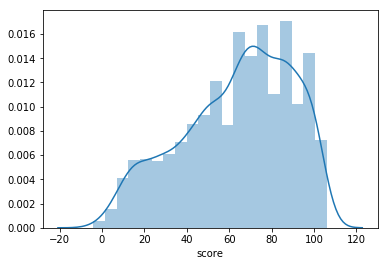

In [52]:
#x = pd.Series(x, name="x variable")
import seaborn as sns
ax = sns.distplot(dfsaida['score'])

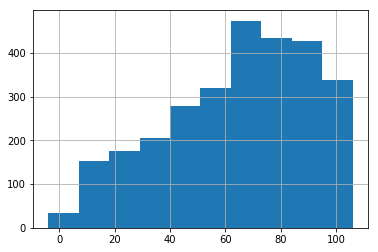

In [53]:
dfsaida.score.hist()

In [54]:
dfsaida.score.value_counts()

 64     54
 73     54
 83     53
 98     52
 69     50
 85     50
 101    49
 84     47
 67     47
 72     46
 77     46
 71     46
 75     46
 74     45
 100    45
 92     44
 89     43
 88     43
 86     43
 68     42
 66     42
 87     41
 65     40
 49     39
 52     38
 62     37
 76     37
 70     37
 53     37
 79     36
        ..
 19     15
 26     15
 15     15
 24     14
 11     14
 22     14
 13     14
 25     13
 10     13
 32     13
 12     12
 23     12
 21     11
 9      10
 8       9
 6       9
 33      9
 104     8
 34      7
 5       7
 7       6
 0       4
 4       3
 2       3
-4       2
 105     2
 1       2
 3       2
 106     2
-1       1
Name: score, Length: 109, dtype: int64

# Corrigindo valores < 0

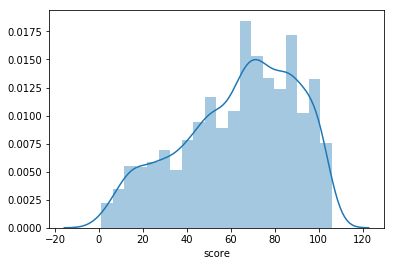

In [55]:
dfsaida['score'] = dfsaida['score'].apply(lambda w: 1 if w <= 0 else w)
import seaborn as sns
ax = sns.distplot(dfsaida['score'])

In [56]:
dfsaida.score.value_counts()

64     54
73     54
83     53
98     52
69     50
85     50
101    49
67     47
84     47
72     46
75     46
71     46
77     46
74     45
100    45
92     44
89     43
86     43
88     43
68     42
66     42
87     41
65     40
49     39
52     38
70     37
62     37
76     37
53     37
97     36
       ..
20     17
35     17
57     17
19     15
15     15
26     15
24     14
13     14
22     14
11     14
10     13
32     13
25     13
23     12
12     12
21     11
9      10
8       9
1       9
6       9
33      9
104     8
34      7
5       7
7       6
2       3
4       3
105     2
3       2
106     2
Name: score, Length: 106, dtype: int64

In [57]:
nome_arquivo = 'Submissao-v5.1-XGBoost.csv'
dfsaida.to_csv(nome_arquivo, index=False)
print('Arquivo %s salvo...', nome_arquivo)
!head Submissao-v5.1-XGBoost.csv

Arquivo %s salvo... Submissao-v5.1-XGBoost.csv
Property Id,score
2637863,88
4988569,85
3129181,76
3129231,35
2658438,102
2646962,96
2746882,85
2658502,98
3114587,106


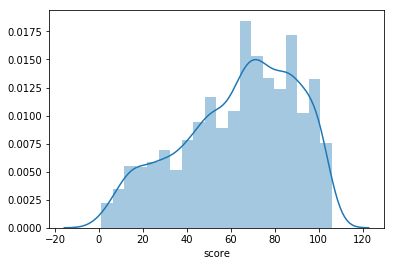

In [58]:
ax = sns.distplot(dfsaida['score'])